In [ ]:
# !sudo apt install swig

In [ ]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
#!pip install vmdpy

In [3]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch
import os
import shutil
import numpy as np

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "UL", "XOM"
]
START_DATE = '2013-01-01'
END_DATE = '2023-12-31'
print(len(TEST_SET))

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()
portfolio_raw_df
portfolio_raw_df.groupby("tic").count()
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
portfolio_norm_df
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_2023 = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

10


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (27680, 8)



/Users/ethan/Documents/GitHub/DSE4212/venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.38369243 0.24161592 0.40684028 ... 0.03291756 0.02330824 0.02918077]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
/Users/ethan/Documents/GitHub/DSE4212/venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5  0.75 1.   ... 0.5  0.75 1.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


In [5]:
import pandas as pd
from vmdpy import VMD

def apply_vmd_to_ticker(df, alpha=5000, tau=0, K=3, DC=0, init=1, tol=1e-7):
    """Applies VMD to the 'close' price for each ticker in the dataframe
    and handles any length mismatch issues."""
    vmd_features = []
    
    # Apply VMD per ticker
    for tic in df['tic'].unique():
        tic_df = df[df['tic'] == tic].copy()  # Filter data for the current ticker
        close_prices = tic_df['close'].to_numpy()  # Extract close prices
        
        # Perform VMD on the close prices
        u, _, _ = VMD(close_prices, alpha, tau, K, DC, init, tol)
        
        # Check if the lengths match, and if not, align them
        if u.shape[1] != len(tic_df):
            print(f"Length mismatch for {tic}: VMD output has {u.shape[1]} points, expected {len(tic_df)}")
            min_len = min(u.shape[1], len(tic_df))
            tic_df = tic_df.iloc[:min_len]  # Truncate the dataframe to match VMD output length
            u = u[:, :min_len]  # Truncate VMD output if necessary
        
        # Assign VMD modes to columns
        for k in range(K):
            tic_df[f'vmd_mode_{k}'] = u[k, :]
        
        # Append the dataframe with VMD modes
        vmd_features.append(tic_df)
    
    # Concatenate all VMD modes into one dataframe
    vmd_df = pd.concat(vmd_features, axis=0)
    
    return vmd_df

# Apply VMD to the training data
df_portfolio_train_vmd = apply_vmd_to_ticker(df_portfolio_train)
df_portfolio_2021_vmd = apply_vmd_to_ticker(df_portfolio_2021)
df_portfolio_2022_vmd = apply_vmd_to_ticker(df_portfolio_2022)
df_portfolio_2023_vmd = apply_vmd_to_ticker(df_portfolio_2023)


Length mismatch for AAPL: VMD output has 250 points, expected 251
Length mismatch for CVX: VMD output has 250 points, expected 251
Length mismatch for GS: VMD output has 250 points, expected 251
Length mismatch for JNJ: VMD output has 250 points, expected 251
Length mismatch for JPM: VMD output has 250 points, expected 251
Length mismatch for MSFT: VMD output has 250 points, expected 251
Length mismatch for PFE: VMD output has 250 points, expected 251
Length mismatch for PG: VMD output has 250 points, expected 251
Length mismatch for UL: VMD output has 250 points, expected 251
Length mismatch for XOM: VMD output has 250 points, expected 251
Length mismatch for AAPL: VMD output has 250 points, expected 251
Length mismatch for CVX: VMD output has 250 points, expected 251
Length mismatch for GS: VMD output has 250 points, expected 251
Length mismatch for JNJ: VMD output has 250 points, expected 251
Length mismatch for JPM: VMD output has 250 points, expected 251
Length mismatch for MSFT: 

In [6]:
TIME_WINDOW = 100
COMISSION_FEE = 0.0025
FEATURE_NAMES = ["close", "high", "low", "vmd_mode_0", "vmd_mode_1", "vmd_mode_2"]
environment_vmd = PortfolioOptimizationEnv(
    df=df_portfolio_train_vmd,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,  # Add VMD modes as features
    normalize_df=None,
    reward_scaling=1.0,
)


# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
    "initial_features": len(FEATURE_NAMES),
}

model = DRLAgent(environment_vmd).get_model("pg", device, model_kwargs, policy_kwargs)

In [7]:
DRLAgent.train_model(model, episodes=30)

  0%|          | 0/30 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 230833.625
Final accumulative portfolio value: 2.30833625
Maximum DrawDown: -0.3111009426660639
Sharpe ratio: 0.7669801316495065


  3%|▎         | 1/30 [00:08<03:53,  8.05s/it]

Initial portfolio value:100000
Final portfolio value: 392953.625
Final accumulative portfolio value: 3.92953625
Maximum DrawDown: -0.21317133467241833
Sharpe ratio: 1.157625329126845


  7%|▋         | 2/30 [00:16<03:46,  8.09s/it]

Initial portfolio value:100000
Final portfolio value: 762374.0
Final accumulative portfolio value: 7.62374
Maximum DrawDown: -0.2678732595655615
Sharpe ratio: 1.292459257920014


 10%|█         | 3/30 [00:24<03:38,  8.10s/it]

Initial portfolio value:100000
Final portfolio value: 1110488.625
Final accumulative portfolio value: 11.10488625
Maximum DrawDown: -0.198551967202093
Sharpe ratio: 1.5268291468248951


 13%|█▎        | 4/30 [00:32<03:33,  8.20s/it]

Initial portfolio value:100000
Final portfolio value: 1105682.25
Final accumulative portfolio value: 11.0568225
Maximum DrawDown: -0.1688034843142736
Sharpe ratio: 1.6832880600758415


 17%|█▋        | 5/30 [00:40<03:26,  8.26s/it]

Initial portfolio value:100000
Final portfolio value: 1520180.25
Final accumulative portfolio value: 15.2018025
Maximum DrawDown: -0.27921479740943067
Sharpe ratio: 1.6529364881817732


 20%|██        | 6/30 [00:49<03:17,  8.21s/it]

Initial portfolio value:100000
Final portfolio value: 1761621.125
Final accumulative portfolio value: 17.61621125
Maximum DrawDown: -0.31953458757456377
Sharpe ratio: 1.5238193298878753


 23%|██▎       | 7/30 [00:57<03:08,  8.20s/it]

Initial portfolio value:100000
Final portfolio value: 2000714.0
Final accumulative portfolio value: 20.00714
Maximum DrawDown: -0.2956133788960169
Sharpe ratio: 1.5767434776602915


 27%|██▋       | 8/30 [01:05<03:02,  8.28s/it]

Initial portfolio value:100000
Final portfolio value: 2202581.0
Final accumulative portfolio value: 22.02581
Maximum DrawDown: -0.28017839009529766
Sharpe ratio: 1.6450219153492893


 30%|███       | 9/30 [01:14<02:57,  8.44s/it]

Initial portfolio value:100000
Final portfolio value: 1989629.25
Final accumulative portfolio value: 19.8962925
Maximum DrawDown: -0.27557019116295145
Sharpe ratio: 1.6318705443395713


 33%|███▎      | 10/30 [01:22<02:48,  8.44s/it]

Initial portfolio value:100000
Final portfolio value: 2283061.75
Final accumulative portfolio value: 22.8306175
Maximum DrawDown: -0.28101538811894966
Sharpe ratio: 1.655446591759768


 37%|███▋      | 11/30 [01:32<02:45,  8.72s/it]

Initial portfolio value:100000
Final portfolio value: 2288821.5
Final accumulative portfolio value: 22.888215
Maximum DrawDown: -0.3036015273522197
Sharpe ratio: 1.6235127771709348


 40%|████      | 12/30 [01:39<02:29,  8.28s/it]

Initial portfolio value:100000
Final portfolio value: 2343420.75
Final accumulative portfolio value: 23.4342075
Maximum DrawDown: -0.2803766477363686
Sharpe ratio: 1.6812133277732455


 43%|████▎     | 13/30 [01:47<02:20,  8.26s/it]

Initial portfolio value:100000
Final portfolio value: 2246867.5
Final accumulative portfolio value: 22.468675
Maximum DrawDown: -0.2599578573875386
Sharpe ratio: 1.7167031925207012


 47%|████▋     | 14/30 [01:56<02:13,  8.34s/it]

Initial portfolio value:100000
Final portfolio value: 2309759.75
Final accumulative portfolio value: 23.0975975
Maximum DrawDown: -0.33432465862487915
Sharpe ratio: 1.6185782341060277


 50%|█████     | 15/30 [02:04<02:04,  8.32s/it]

Initial portfolio value:100000
Final portfolio value: 2302633.75
Final accumulative portfolio value: 23.0263375
Maximum DrawDown: -0.2803732322018909
Sharpe ratio: 1.6527070791559382


 53%|█████▎    | 16/30 [02:12<01:55,  8.27s/it]

Initial portfolio value:100000
Final portfolio value: 2757641.75
Final accumulative portfolio value: 27.5764175
Maximum DrawDown: -0.2803820503859764
Sharpe ratio: 1.728761133555847


 57%|█████▋    | 17/30 [02:21<01:47,  8.28s/it]

Initial portfolio value:100000
Final portfolio value: 3001071.0
Final accumulative portfolio value: 30.01071
Maximum DrawDown: -0.2979920939867785
Sharpe ratio: 1.7625305090937249


 60%|██████    | 18/30 [02:29<01:39,  8.28s/it]

Initial portfolio value:100000
Final portfolio value: 271981.375
Final accumulative portfolio value: 2.71981375
Maximum DrawDown: -0.3012595819506044
Sharpe ratio: 0.7326548800288868


 63%|██████▎   | 19/30 [02:36<01:28,  8.03s/it]

Initial portfolio value:100000
Final portfolio value: 186265.75
Final accumulative portfolio value: 1.8626575
Maximum DrawDown: -0.30125932080085904
Sharpe ratio: 0.5004702515995841


 67%|██████▋   | 20/30 [02:44<01:19,  7.93s/it]

Initial portfolio value:100000
Final portfolio value: 197136.578125
Final accumulative portfolio value: 1.97136578125
Maximum DrawDown: -0.30125873863644115
Sharpe ratio: 0.5377266532269523


 70%|███████   | 21/30 [02:51<01:09,  7.75s/it]

Initial portfolio value:100000
Final portfolio value: 198425.015625
Final accumulative portfolio value: 1.98425015625
Maximum DrawDown: -0.3012597239192827
Sharpe ratio: 0.5418520177789944


 73%|███████▎  | 22/30 [02:59<01:01,  7.66s/it]

Initial portfolio value:100000
Final portfolio value: 198516.359375
Final accumulative portfolio value: 1.98516359375
Maximum DrawDown: -0.301259411192511
Sharpe ratio: 0.5421210319288907


 77%|███████▋  | 23/30 [03:06<00:52,  7.56s/it]

Initial portfolio value:100000
Final portfolio value: 198663.421875
Final accumulative portfolio value: 1.98663421875
Maximum DrawDown: -0.3012595235772324
Sharpe ratio: 0.5425807018154889


 80%|████████  | 24/30 [03:14<00:45,  7.57s/it]

Initial portfolio value:100000
Final portfolio value: 198903.484375
Final accumulative portfolio value: 1.98903484375
Maximum DrawDown: -0.30125942522502513
Sharpe ratio: 0.5433433457659215


 83%|████████▎ | 25/30 [03:21<00:37,  7.59s/it]

Initial portfolio value:100000
Final portfolio value: 199155.265625
Final accumulative portfolio value: 1.99155265625
Maximum DrawDown: -0.3012602449013524
Sharpe ratio: 0.5441467842970849


 87%|████████▋ | 26/30 [03:29<00:30,  7.61s/it]

Initial portfolio value:100000
Final portfolio value: 199493.9375
Final accumulative portfolio value: 1.994939375
Maximum DrawDown: -0.3012595614376994
Sharpe ratio: 0.5452254179373469


 90%|█████████ | 27/30 [03:37<00:23,  7.75s/it]

Initial portfolio value:100000
Final portfolio value: 200221.921875
Final accumulative portfolio value: 2.00221921875
Maximum DrawDown: -0.30125936886924254
Sharpe ratio: 0.5475430681800489


 93%|█████████▎| 28/30 [03:45<00:15,  7.68s/it]

Initial portfolio value:100000
Final portfolio value: 201638.265625
Final accumulative portfolio value: 2.01638265625
Maximum DrawDown: -0.3012593927255135
Sharpe ratio: 0.5519663827879868


 97%|█████████▋| 29/30 [03:52<00:07,  7.71s/it]

Initial portfolio value:100000
Final portfolio value: 203123.28125
Final accumulative portfolio value: 2.0312328125
Maximum DrawDown: -0.3012596740750767
Sharpe ratio: 0.5564938946755592


100%|██████████| 30/30 [04:01<00:00,  8.04s/it]


In [8]:
torch.save(model.train_policy.state_dict(), "policy_with_VMD.pt")

Evaluation

In [10]:
environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021_vmd,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_scaling=1.0,
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022_vmd,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_scaling=1.0,
)

environment_2023 = PortfolioOptimizationEnv(
    df_portfolio_2023_vmd,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_scaling=1.0,
)

EIIE_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW,initial_features=len(FEATURE_NAMES), device=device)
policy.load_state_dict(torch.load("policy_with_VMD.pt"))
environment_vmd.reset()

src_folder = "results/rl"
dst_folder = "results/train"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(model, environment_vmd, policy=policy)
os.rename(src_folder, dst_folder)
EIIE_results["train"]["value"] = environment_vmd._asset_memory["final"]
EIIE_results["train"]["actions"] = environment_vmd._actions_memory

# 2021
src_folder = "results/rl"
dst_folder = "results/2021"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
os.rename(src_folder, dst_folder)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]
EIIE_results["2021"]["actions"] = environment_2021._actions_memory


# 2022
src_folder = "results/rl"
dst_folder = "results/2022"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
os.rename(src_folder, dst_folder)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]
EIIE_results["2022"]["actions"] = environment_2022._actions_memory


# 2023
src_folder = "results/rl"
dst_folder = "results/2023"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(model, environment_2023, policy=policy)
os.rename(src_folder, dst_folder)
EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]
EIIE_results["2023"]["actions"] = environment_2023._actions_memory


#uniform buy n hold
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment_vmd.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_vmd.step(action)
UBAH_results["train"]["value"] = environment_vmd._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
terminated = False
environment_2023.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2023.step(action)
UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_5857/3015494156.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_wit

Initial portfolio value:100000
Final portfolio value: 155536.46875
Final accumulative portfolio value: 1.5553646875
Maximum DrawDown: -0.30131342428150487
Sharpe ratio: 0.3834679571365425
Initial portfolio value:100000
Final portfolio value: 98085.015625
Final accumulative portfolio value: 0.98085015625
Maximum DrawDown: -0.12712217464354447
Sharpe ratio: -0.11930289573409114
Initial portfolio value:100000
Final portfolio value: 104497.4609375
Final accumulative portfolio value: 1.044974609375
Maximum DrawDown: -0.1411937035834092
Sharpe ratio: 0.47536517452558774
Initial portfolio value:100000
Final portfolio value: 111463.53125
Final accumulative portfolio value: 1.1146353125
Maximum DrawDown: -0.14327808483639148
Sharpe ratio: 0.9855511556462571
Initial portfolio value:100000
Final portfolio value: 242561.671875
Final accumulative portfolio value: 2.42561671875
Maximum DrawDown: -0.34678755451399124
Sharpe ratio: 0.7455223905067975
Initial portfolio value:100000
Final portfolio valu

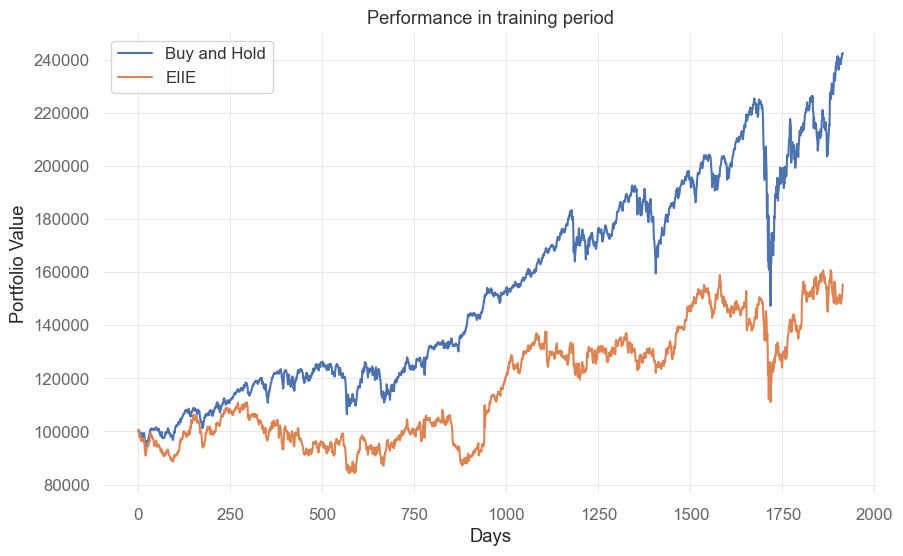

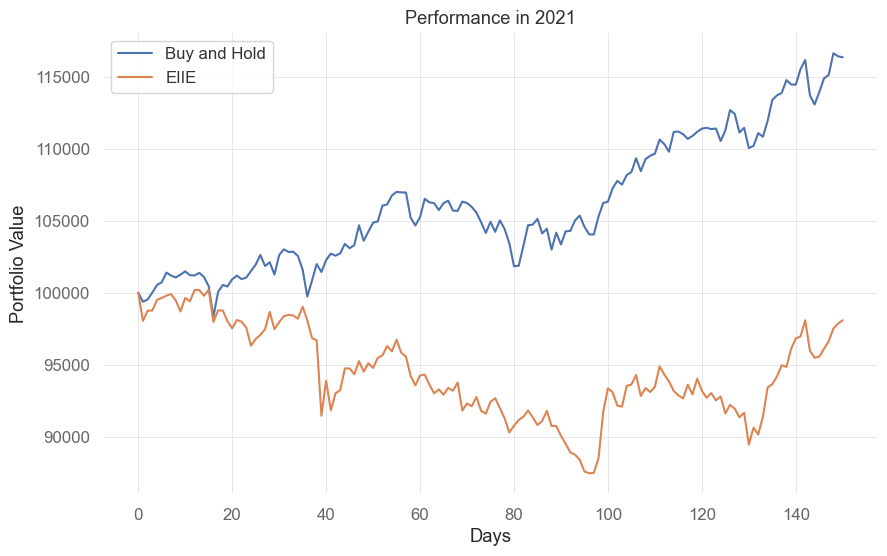

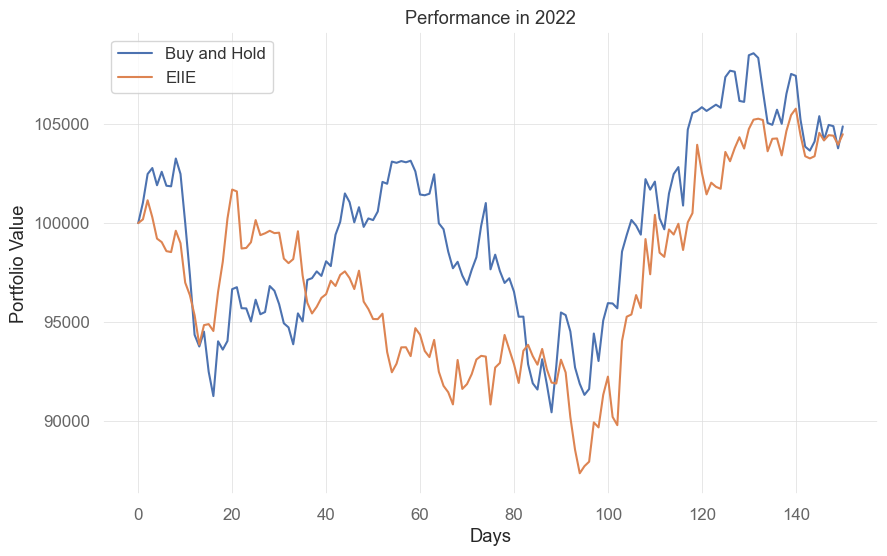

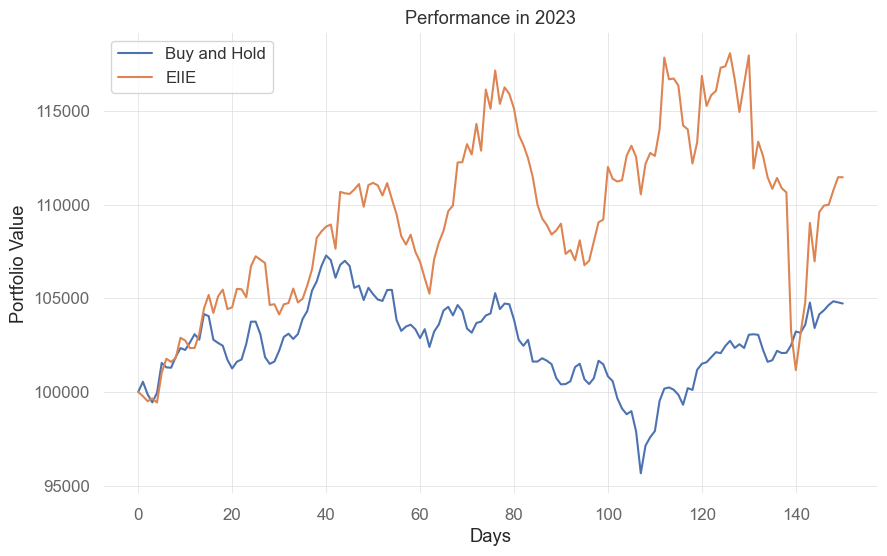

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

plt.plot(UBAH_results["2023"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2023"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2023")
plt.legend()

plt.show()

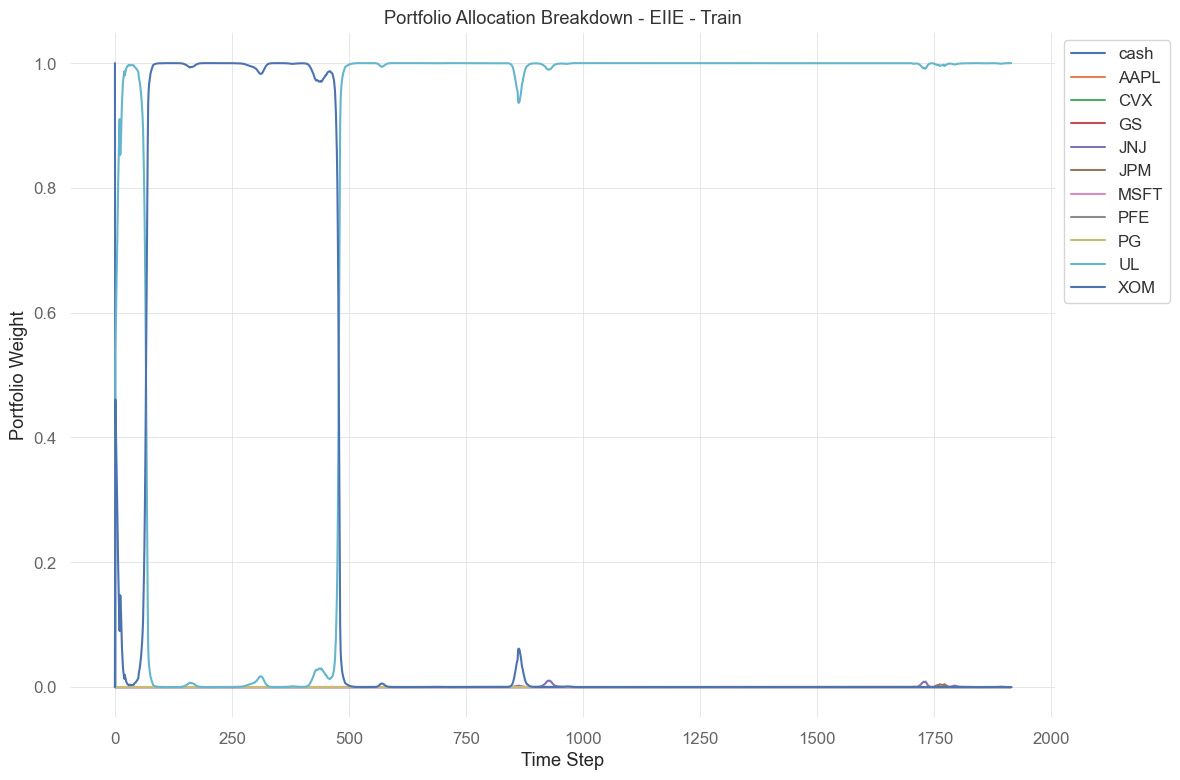

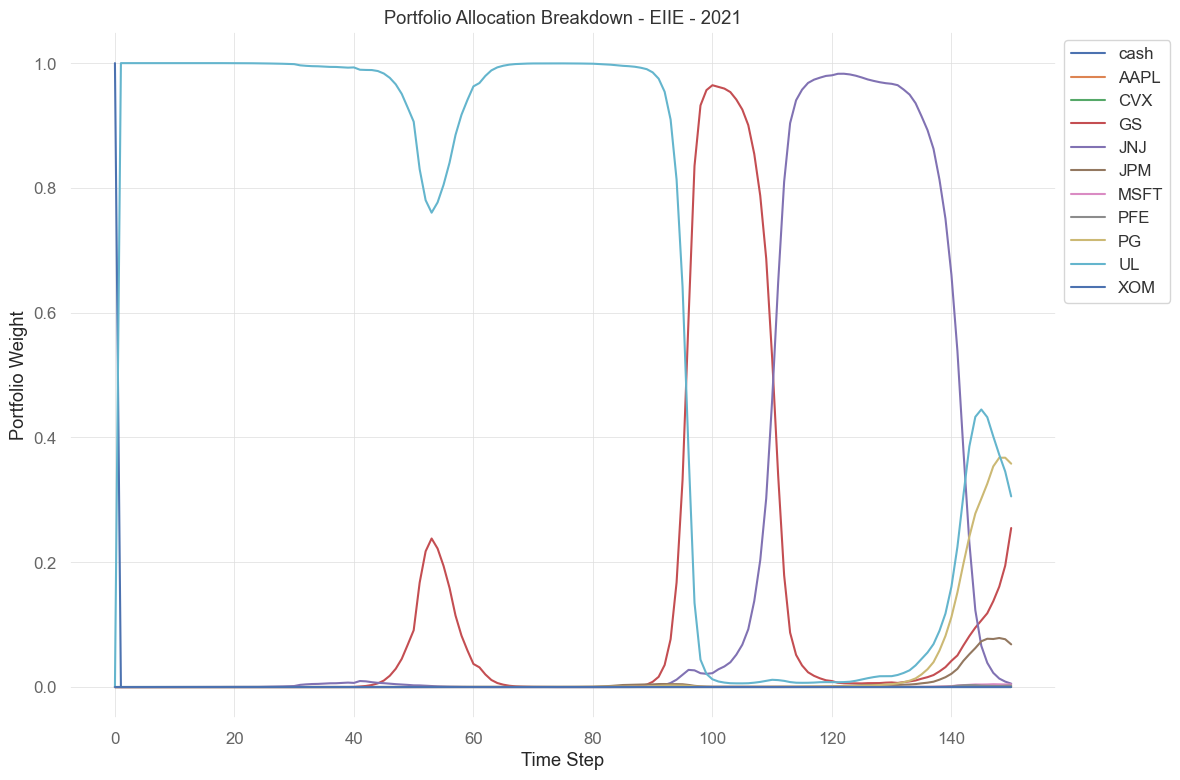

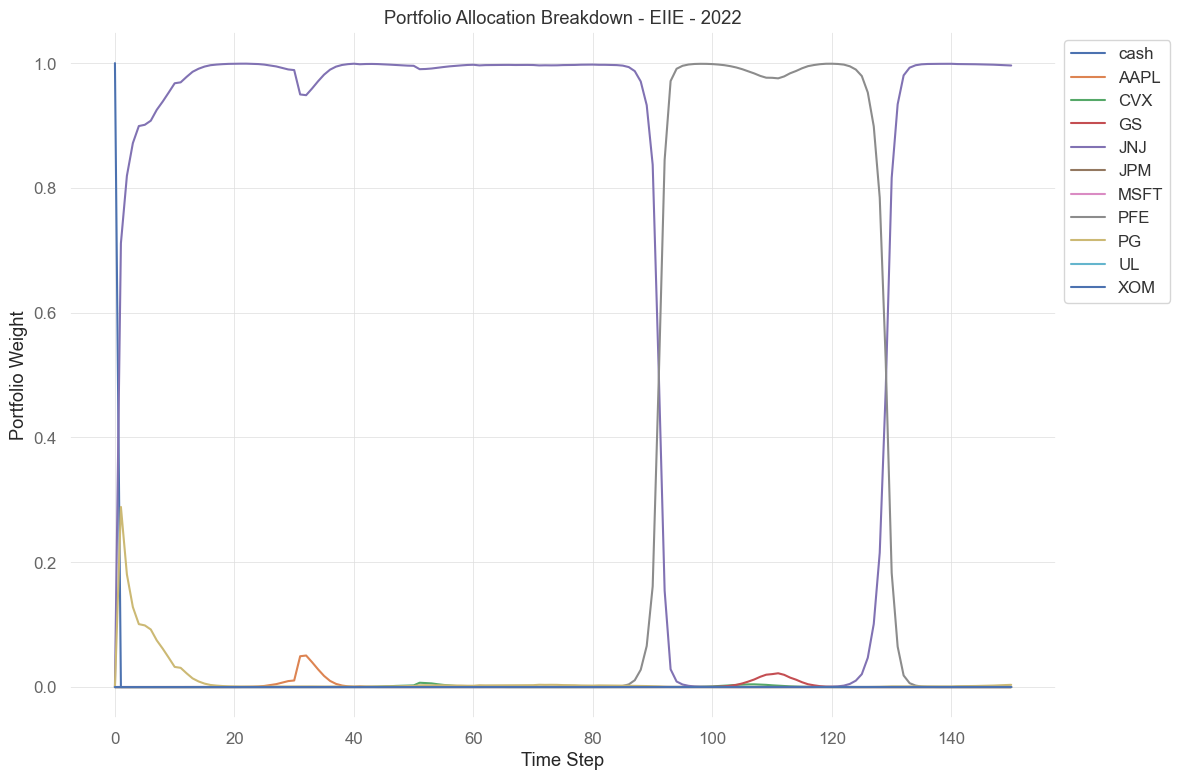

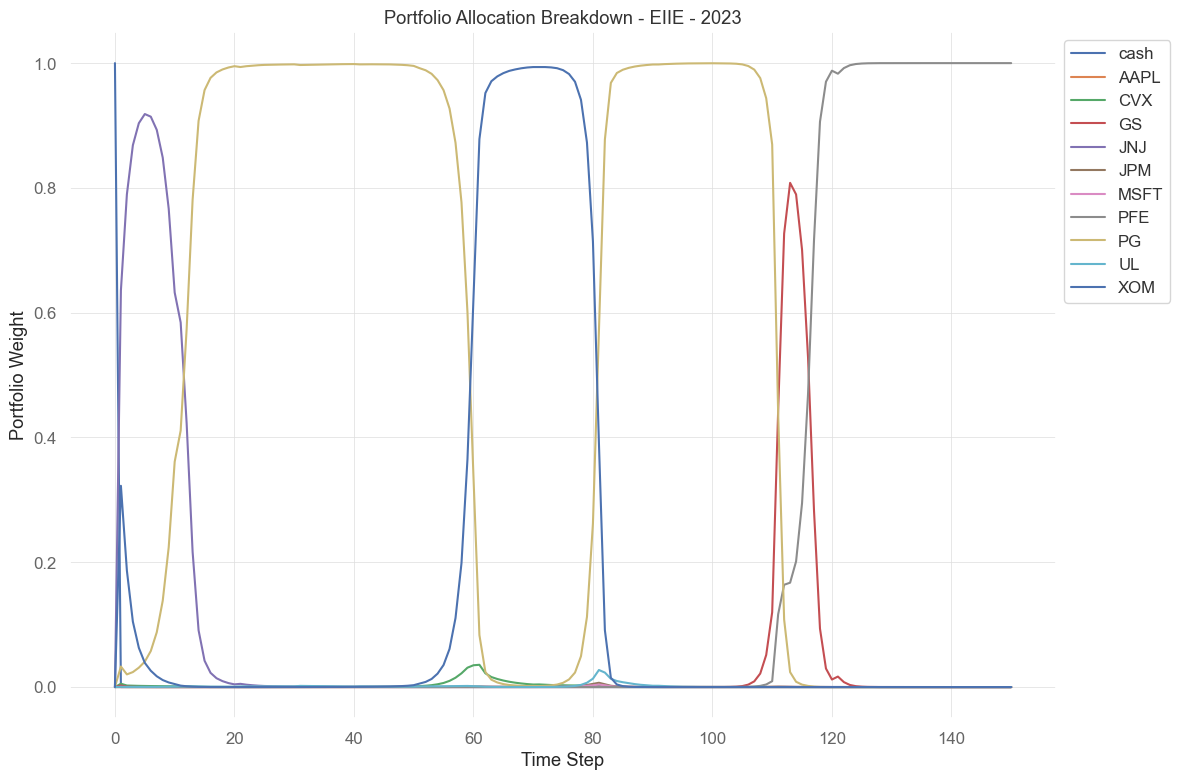

In [12]:
def plot_action_memory(actions, tickers, label):
    """Visualize portfolio allocation over time."""
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    actions_df.plot(kind="line", figsize=(12, 8), title=f"Portfolio Allocation Breakdown - {label}")
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Time Step")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot EIIE actions for the training period
plot_action_memory(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train")

# Plot EIIE actions for 2021
plot_action_memory(EIIE_results["2021"]["actions"], TEST_SET, "EIIE - 2021")

# Plot EIIE actions for 2022
plot_action_memory(EIIE_results["2022"]["actions"], TEST_SET, "EIIE - 2022")

# Plot EIIE actions for 2023
plot_action_memory(EIIE_results["2023"]["actions"], TEST_SET, "EIIE - 2023")